##  Import Libraries

In [31]:
#Importing the necessary libraries
import pandas as pd
import pystac
import fsspec
import xarray as xr
import datetime 
import numpy as np
import math
from tqdm import tqdm
from datetime import date
import pystac
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import dalex as dx

import warnings
warnings.filterwarnings("ignore")

## Data Load

### Extract Terra Climate Catalogue

In [32]:
# Extracting data from Planetary Computer Terra Climate catalog
url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
asset = collection.assets["zarr-https"]
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                 (time: 744, lat: 4320, lon: 8640, crs: 1)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * lon                     (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                    (time) datetime64[ns] 1958-01-01 ... 2019-12-01
Data variables: (12/18)
    aet                     (time, lat, lon) float32 ...
    def                     (time, lat, lon) float32 ...
    pdsi                    (time, lat, lon) float32 ...
    pet                     (time, lat, lon) float32 ...
    ppt                     (time, lat, lon) float32 ...
    ppt_station_influence   (time, lat, lon) float32 ...
    ...                      ...
    tmin                    (time, lat, lon) float32 ...
    tmin_station_influence  (time, lat, lon) float32 ...
    vap                     (time, lat, lon) float32 ...
    vap_station_influence   (time, lat, lon) float32 ...
    vpd                     (time, lat, lon) float32 ...
    ws                      (time, lat, lon) float32 ...

### Load Frog Presence Data

In [33]:
path_frog_presence_aus = "Data\BWW Challenge 2022 Level 3 Frog_Occurence_Australia.csv"
df_frog_aus=pd.read_csv(path_frog_presence_aus,usecols=['eventDate','year','month','decimalLatitude','decimalLongitude','occurrenceStatus',"stateProvince"])

print(df_frog_aus.shape)
df_frog_aus["eventDate"] = pd.to_datetime(df_frog_aus["eventDate"])
df_frog_aus.head()

(125621, 7)


,occurrenceStatus,eventDate,year,month,stateProvince,decimalLatitude,decimalLongitude
0,PRESENT,2017-11-14,2017,11,Vic,-38.1,144.6
1,PRESENT,2017-11-25,2017,11,Qld,-26.7,153.1
2,PRESENT,2018-01-03,2018,1,Nsw,-30.3,152.9
3,PRESENT,2018-01-26,2018,1,Nt,-12.6,131.1
4,PRESENT,2018-02-06,2018,2,Qld,-26.3,152.9


In [34]:
path_frog_presence_SA_CR = "Data\BWW Challenge 2022 Level 3 Frog_Occurence_South_Africa_and_Costa_Rica.csv"
df_frog_SA_CR=pd.read_csv(path_frog_presence_SA_CR,usecols=['eventDate','year','month','decimalLatitude','decimalLongitude','occurrenceStatus',"stateProvince"])

print(df_frog_SA_CR.shape)
df_frog_SA_CR["eventDate"] = pd.to_datetime(df_frog_SA_CR["eventDate"])
df_frog_SA_CR.head()

(6670, 7)


,occurrenceStatus,eventDate,year,month,stateProvince,decimalLatitude,decimalLongitude
0,PRESENT,2018-01-07 14:59:00,2018,1,Limón,10.438840,-83.786274
1,PRESENT,2017-11-06 08:31:00,2017,11,Mpumalanga,-24.926687,31.476465
2,PRESENT,2019-08-04 03:22:00,2019,8,Puntarenas,9.389377,-84.142044
3,PRESENT,2018-01-15 21:15:00,2018,1,Limón,10.440689,-83.785854
4,PRESENT,2018-01-04 14:22:00,2018,1,Limón,10.440703,-83.786194


### Grid based approach for extracting frog count 
#### For calculating the frog density over Australia, we will create a grid of 225 sq. kms then we will evaluate the frog presence points on each of the grid

### Australia region bbox

In [35]:
# Australia region bbox(excluding "Tasmania" region)
aus = {"type":"Polygon",
       "coordinates":[[[153.896484,-39.327584],[113.062499,-39.327584],
                       [113.062499,-10.521216],[153.896484,-10.521216],[153.896484,-39.327584]]]}
aus["coordinates"] = aus["coordinates"][0][0:4]
min_longi = min(aus["coordinates"])[0]
max_longi = max(aus["coordinates"])[0]
min_lati =  min(aus["coordinates"])[1]
max_lati = max(aus["coordinates"])[1]

print("min_lati = ",min_lati,"\n","min_longi = ",min_longi,"\n","max_lati = ",max_lati,"\n","max_longi = ",max_longi)

min_lati =  -39.327584 
 min_longi =  113.062499 
 max_lati =  -10.521216 
 max_longi =  153.896484


In [36]:
## Australia region bbox for "Tasmania" region
tas = {"type":"Polygon",
       "coordinates":[[[148.541748,-39.398856],[143.802246,-39.398856],
                       [143.802246,-43.69331],[148.541748,-43.69331],[148.541748,-39.398856]]]}
tas["coordinates"] = tas["coordinates"][0][0:4]

min_longi_tas = min(tas["coordinates"])[0]
max_longi_tas = max(tas["coordinates"])[0]
min_lati_tas =  min(tas["coordinates"])[1]
max_lati_tas = max(tas["coordinates"])[1]

print("min_lati = ",min_lati_tas,"\n","min_longi = ",min_longi_tas,"\n","max_lati = ",max_lati_tas,"\n","max_longi = ",max_longi_tas)

min_lati =  -43.69331 
 min_longi =  143.802246 
 max_lati =  -39.398856 
 max_longi =  148.541748


In [37]:
# Combining the whole of Australia including Tasmania region 
aus_whole = {"min_lati":min_lati_tas,"max_lati":max_lati,"min_longi":min_longi,"max_longi":max_longi}
tas_only = {"min_lati":min_lati_tas,"max_lati":max_lati_tas,"min_longi":min_longi_tas,"max_longi":max_longi_tas}

### Grid formation

In [38]:
#Using grid based approach, creating 225 sq.kms grid, the approx. difference between lat-lon for 225 sq.kms area : lat is 0.1331 and lon is 0.15365 respectively
#66500 grids formulated for the entire region of Australia
bbox_grid_whole = [({"min_x":np.round(x,4), "min_y":np.round(y,4), "max_x":np.round(x + 0.15365,4),
                     "max_y":np.round(y + .1331,4)}) for x, y in itertools.product(np.arange(aus_whole["min_longi"], aus_whole["max_longi"],0.15365),
                                                                                   np.arange(aus_whole["min_lati"], aus_whole["max_lati"],.1331))]
print(len(bbox_grid_whole))

bbox_grid_tas = [({"min_x":np.round(x,4), "min_y":np.round(y,4), "max_x":np.round(x + 0.15365,4),
                     "max_y":np.round(y + .1331,4)}) for x, y in itertools.product(np.arange(tas_only["min_longi"], tas_only["max_longi"],0.15365),
                                                                                   np.arange(tas_only["min_lati"], tas_only["max_lati"],.1331))]
print(len(bbox_grid_tas))

66500
1023


In [39]:
# Calculate the frog count (greater than 0) by iterating through each of the grid and subsetting frog presence data, 
#append to a dictionary with bounding box coordinates and shape of the subset data as - frog count
filt_lat = {}
i=1
for _,bbox in tqdm(enumerate(bbox_grid_whole)):  
    longi_lati_df_rang = df_frog_aus[((df_frog_aus['decimalLongitude'] >= bbox["min_x"]) & (df_frog_aus['decimalLongitude'] <= bbox["max_x"])) & 
                           ((df_frog_aus['decimalLatitude'] >= bbox["min_y"]) & (df_frog_aus['decimalLatitude'] <=bbox["max_y"]))]
    if longi_lati_df_rang.shape[0]>0:
        filt_lat[i] ={}
        filt_lat[i]["coord"] = bbox
        filt_lat[i]["frog_count"] = longi_lati_df_rang.shape[0]
        i=i+1
aus_whole_filt_cord = filt_lat

# Calculate the frog count (greater than 0) by iterating through each of the grid and subsetting frog presence data, 
#append to a dictionary with bounding box coordinates and shape of the subset data as - frog count
filt_lat_tas = {}
i=1
for _,bbox in tqdm(enumerate(bbox_grid_tas)):  
    longi_lati_df_rang = df_frog_aus[((df_frog_aus['decimalLongitude'] >= bbox["min_x"]) & (df_frog_aus['decimalLongitude'] <= bbox["max_x"])) & 
                           ((df_frog_aus['decimalLatitude'] >= bbox["min_y"]) & (df_frog_aus['decimalLatitude'] <=bbox["max_y"]))]
    if longi_lati_df_rang.shape[0]>0:
        filt_lat_tas[i] ={}
        filt_lat_tas[i]["coord"] = bbox
        filt_lat_tas[i]["frog_count"] = longi_lati_df_rang.shape[0]
        i=i+1
tas_only_filt_cord = filt_lat_tas

66500it [03:47, 292.22it/s]
1023it [00:04, 227.37it/s]


In [40]:
# Sample dictionary with bounding box and frog count
print(dict(list(aus_whole_filt_cord.items())[0:2]))

print(dict(list(tas_only_filt_cord.items())[0:2]))

{1: {'coord': {'min_x': 113.6771, 'min_y': -24.9262, 'max_x': 113.8307, 'max_y': -24.7931}, 'frog_count': 1}, 2: {'coord': {'min_x': 114.138, 'min_y': -27.7213, 'max_x': 114.2917, 'max_y': -27.5882}, 'frog_count': 8}}
{1: {'coord': {'min_x': 143.8022, 'min_y': -39.9665, 'max_x': 143.9559, 'max_y': -39.8334}, 'frog_count': 12}, 2: {'coord': {'min_x': 143.9559, 'min_y': -40.0996, 'max_x': 144.1095, 'max_y': -39.9665}, 'frog_count': 20}}


In [41]:
# Converting the frog_id dictionary to dataframe having 2660 rows & 6 columns
aus_whole_filt_cord_df = pd.DataFrame.from_dict(aus_whole_filt_cord,orient="index")

aus_whole_filt_cord_df["min_lon"] = [i["min_x"] for i in aus_whole_filt_cord_df["coord"]]
aus_whole_filt_cord_df["min_lat"] = [i["min_y"] for i in aus_whole_filt_cord_df["coord"]]

aus_whole_filt_cord_df["max_lon"] = [i["max_x"] for i in aus_whole_filt_cord_df["coord"]]
aus_whole_filt_cord_df["max_lat"] = [i["max_y"] for i in aus_whole_filt_cord_df["coord"]]


print(aus_whole_filt_cord_df.shape)
aus_whole_filt_cord_df.head()

# Converting the frog_id dictionary to dataframe having 2660 rows & 6 columns
tas_only_filt_cord_df = pd.DataFrame.from_dict(tas_only_filt_cord,orient="index")

tas_only_filt_cord_df["min_lon"] = [i["min_x"] for i in tas_only_filt_cord_df["coord"]]
tas_only_filt_cord_df["min_lat"] = [i["min_y"] for i in tas_only_filt_cord_df["coord"]]

tas_only_filt_cord_df["max_lon"] = [i["max_x"] for i in tas_only_filt_cord_df["coord"]]
tas_only_filt_cord_df["max_lat"] = [i["max_y"] for i in tas_only_filt_cord_df["coord"]]


print(tas_only_filt_cord_df.shape)
tas_only_filt_cord_df.head()


(2660, 6)
(178, 6)


,coord,frog_count,min_lon,min_lat,max_lon,max_lat
1,"{'min_x': 143.8022, 'min_y': -39.9665, 'max_x'...",12,143.8022,-39.9665,143.9559,-39.8334
2,"{'min_x': 143.9559, 'min_y': -40.0996, 'max_x'...",20,143.9559,-40.0996,144.1095,-39.9665
3,"{'min_x': 143.9559, 'min_y': -39.9665, 'max_x'...",6,143.9559,-39.9665,144.1095,-39.8334
4,"{'min_x': 143.9559, 'min_y': -39.8334, 'max_x'...",2,143.9559,-39.8334,144.1095,-39.7003
5,"{'min_x': 143.9559, 'min_y': -39.7003, 'max_x'...",1,143.9559,-39.7003,144.1095,-39.5672


In [42]:
# Selecting time frame based on frogid dataset
ds_date = ds.sel(time = slice("2017-11-01","2019-11-01"))

display(ds_date)

len(ds_date)

# filtering data for Austrlia region based on coordinates
ds_tas = ds_date.where((ds.lat>=tas_only["min_lati"]) & (ds.lat<=tas_only["max_lati"]) & 
                       ((ds.lon>=tas_only["min_longi"] ) & (ds.lon<=tas_only["max_longi"])),drop = True)
print(ds_tas)
#  Converting the xarray format to pandas dataframe 
ds_tas = ds_tas.to_dataframe().reset_index()

ds_tas["time"] = pd.to_datetime(ds_tas["time"])

<xarray.Dataset>
Dimensions:                 (time: 25, lat: 4320, lon: 8640, crs: 1)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * lon                     (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                    (time) datetime64[ns] 2017-11-01 ... 2019-11-01
Data variables: (12/18)
    aet                     (time, lat, lon) float32 ...
    def                     (time, lat, lon) float32 ...
    pdsi                    (time, lat, lon) float32 ...
    pet                     (time, lat, lon) float32 ...
    ppt                     (time, lat, lon) float32 ...
    ppt_station_influence   (time, lat, lon) float32 ...
    ...                      ...
    tmin                    (time, lat, lon) float32 ...
    tmin_station_influence  (time, lat, lon) float32 ...
    vap                     (time, lat, lon) float32 ...
    vap_station_influence   (time, lat, lon) float32 ...
    vpd                     (time, lat, lon) float32 ...
    ws                      (time, lat, lon) float32 ...

<xarray.Dataset>
Dimensions:                 (time: 25, lat: 103, lon: 114, crs: 1)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 -39.44 -39.48 -39.52 ... -43.65 -43.69
  * lon                     (lon) float64 143.8 143.9 143.9 ... 148.5 148.5
  * time                    (time) datetime64[ns] 2017-11-01 ... 2019-11-01
Data variables: (12/18)
    aet                     (time, lat, lon) float32 nan nan nan ... nan nan nan
    def                     (time, lat, lon) float32 nan nan nan ... nan nan nan
    pdsi                    (time, lat, lon) float32 nan nan nan ... nan nan nan
    pet                     (time, lat, lon) float32 nan nan nan ... nan nan nan
    ppt                     (time, lat, lon) float32 nan nan nan ... nan nan nan
    ppt_station_influence   (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                      ...
    tmin                    (time, lat, lon) float32 nan nan nan ... nan nan nan
    

In [43]:
# Iterate the Terra climate lat-lon across the grids for averaging the terraclimate values for a particular lat-Lon
for ind,row in tqdm(tas_only_filt_cord_df.iterrows()):

    
    longi_lati_df_rang = ds_tas[(ds_tas['lon'] >= row["min_lon"]) & (ds_tas['lon'] <= row["max_lon"]) & 
                           (ds_tas['lat'] >= row["min_lat"]) & (ds_tas['lat'] <=row["max_lat"])]
    
    
    col = [{var:longi_lati_df_rang[var].mean()} for var in longi_lati_df_rang[longi_lati_df_rang.columns[4:]]]
    
    for var in col:
        for key,val in var.items():
#             print(key,val)
            tas_only_filt_cord_df.loc[ind,key] = val
    
    tas_only_filt_cord_df.loc[ind,"samples_count"] = longi_lati_df_rang.shape[0]

178it [00:03, 52.85it/s]


In [44]:
# Shape of final dataset 
tas_only_filt_cord_df.shape

(178, 25)

In [45]:
# Copying 'tas_only_filt_cord_df' to new variable - 'df_tas_225_2yr'
df_tas_225_2yr = tas_only_filt_cord_df.copy()
df_tas_225_2yr.head(2)

,coord,frog_count,min_lon,min_lat,max_lon,max_lat,aet,def,pdsi,pet,...,swe,tmax,tmax_station_influence,tmin,tmin_station_influence,vap,vap_station_influence,vpd,ws,samples_count
1,"{'min_x': 143.8022, 'min_y': -39.9665, 'max_x'...",12,143.8022,-39.9665,143.9559,-39.8334,52.217777,42.742222,-2.230222,94.871109,...,0.0,17.329334,0.0,10.887113,0.0,1.157067,0.0,0.446578,6.952000,300.0
2,"{'min_x': 143.9559, 'min_y': -40.0996, 'max_x'...",20,143.9559,-40.0996,144.1095,-39.9665,54.796665,39.273335,-2.169333,94.033333,...,0.0,17.139336,0.0,10.747334,0.0,1.144367,0.0,0.440667,7.006667,300.0


In [46]:
# Data preprocessing

# selecting relevant columns and appending frog count column
sel_col = df_tas_225_2yr.columns[6:].to_list()
sel_col.extend(["frog_count"])
print(len(sel_col))

# delete the 'samples_count' column
df_model_data = df_tas_225_2yr[sel_col]
del df_model_data["samples_count"]
df_model_data.head(2)

20


,aet,def,pdsi,pet,ppt,ppt_station_influence,q,soil,srad,swe,tmax,tmax_station_influence,tmin,tmin_station_influence,vap,vap_station_influence,vpd,ws,frog_count
1,52.217777,42.742222,-2.230222,94.871109,74.617775,0.0,22.657778,25.32,176.662216,0.0,17.329334,0.0,10.887113,0.0,1.157067,0.0,0.446578,6.952000,12
2,54.796665,39.273335,-2.169333,94.033333,80.959999,0.0,26.440000,25.77,175.023331,0.0,17.139336,0.0,10.747334,0.0,1.144367,0.0,0.440667,7.006667,20


In [47]:
# Checking for missing values % for respective variables
for col in df_model_data.columns:
    miss_value_number = df_model_data[col].isna().sum()
    mis = ((df_model_data[col].isna().sum())/df_model_data[col].shape[0])*100
    print("missing valuein {} : is {} ---> {}%".format(col,miss_value_number,mis))

missing valuein aet : is 0 ---> 0.0%
missing valuein def : is 0 ---> 0.0%
missing valuein pdsi : is 0 ---> 0.0%
missing valuein pet : is 0 ---> 0.0%
missing valuein ppt : is 0 ---> 0.0%
missing valuein ppt_station_influence : is 0 ---> 0.0%
missing valuein q : is 0 ---> 0.0%
missing valuein soil : is 0 ---> 0.0%
missing valuein srad : is 0 ---> 0.0%
missing valuein swe : is 0 ---> 0.0%
missing valuein tmax : is 0 ---> 0.0%
missing valuein tmax_station_influence : is 0 ---> 0.0%
missing valuein tmin : is 0 ---> 0.0%
missing valuein tmin_station_influence : is 0 ---> 0.0%
missing valuein vap : is 0 ---> 0.0%
missing valuein vap_station_influence : is 0 ---> 0.0%
missing valuein vpd : is 0 ---> 0.0%
missing valuein ws : is 0 ---> 0.0%
missing valuein frog_count : is 0 ---> 0.0%


In [48]:
# Dropping missing values and checking the final shape of data (2655,19)
df_model_data = df_model_data.dropna()
df_model_data.shape

(178, 19)

### Outlier Capping

In [49]:
# Outliers capping for treating outliers
def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    return x

df_model_data.iloc[:,0:-1]=df_model_data.iloc[:,0:-1].apply(lambda x: outlier_capping(x))

In [50]:
# Checking unique values for the below columns
df_model_data[["ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence"]].value_counts().reset_index(name='Count')

,ppt_station_influence,vap_station_influence,tmax_station_influence,tmin_station_influence,Count
0,0.0,0.0,0.0,0.0,178


In [51]:
# Dropping columns with only 0 values in the weather data
df_model_data.drop(["ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence"],
                   axis=1, inplace=True)

### Correlation Matrix

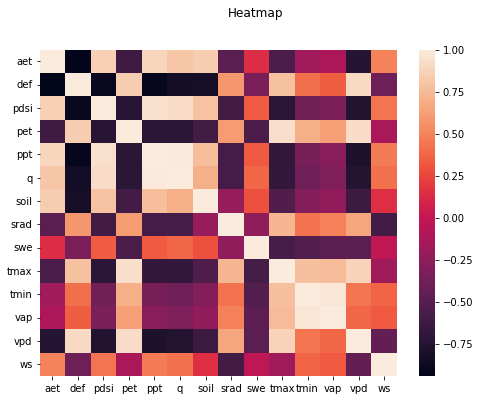

In [52]:
# Correlation matrix visualization
plt.figure(figsize=(8,6))
sns.heatmap(df_model_data.iloc[:,0:-1].corr())
plt.suptitle('Heatmap')
plt.show()

In [53]:
# Data distribution of column - 'swe'
df_model_data['swe'].value_counts()

0.000000    159
2.263133      2
0.003333      2
0.311111      1
0.005000      1
0.676667      1
0.133333      1
0.110000      1
0.050000      1
0.593333      1
0.200000      1
0.393333      1
1.666667      1
0.655000      1
0.137500      1
1.156667      1
1.576667      1
1.190000      1
Name: swe, dtype: int64

In [54]:
# Dropping column - 'swe' as most of the values are 0
df_model_data.drop(["swe"],axis = 1,inplace = True)

### Outlier treatment for Target variable 

<AxesSubplot:xlabel='frog_count'>

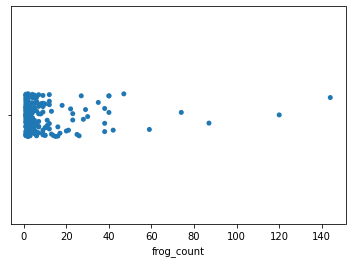

In [55]:
# Visulalisation for selecting the frog count
import seaborn as sns
sns.stripplot(df_model_data['frog_count'])

In [56]:
# Setting upper limit as less than 500 for frog count 
upper = 500
df_model_data = df_model_data[(df_model_data['frog_count'] < upper)]

## Model building

In [57]:
# Splitting the feature and target set to x and y
x = df_model_data.iloc[:,0:-1]
y = df_model_data["frog_count"].values

In [58]:
# Spliting the data into training and validation set based on 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [59]:
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(124, 13)
(124,)
(54, 13)
(54,)


### Model normalization using minmaxscaler

In [60]:
# Data normalization using Minmaxscaler
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

### Multicollinearity treatment for predictor variables

In [61]:
# Generating VIF scores & dropping variables having high VIF to avoid multicollinearity
F = pd.DataFrame(X_train_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = F.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(F.values, i) for i in range(len(F.columns))]

print(vif_data)

  feature        VIF
0     aet  31.339362
1    pdsi  31.741994
2       q  10.728650
3    soil  16.634442
4     vap  18.189328
5     vpd   8.308163
6      ws  14.432547


In [62]:
# Dropping columns based on VIF score > 50
X_train_mm=pd.DataFrame(X_train_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
X_train_mm=X_train_mm.values
X_test_mm=pd.DataFrame(X_test_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
X_test_mm=X_test_mm.values

### Model checkpoint & building the architecture

In [63]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath='alternate_best_model_adam_225_2yr_updated_VIF.hdf5',
                             monitor='val_loss',verbose=1,save_weights_only=True,save_best_only=True,mode='min')

# model architecture for ANN model
model = Sequential()
model.add(Dense(512, activation="relu", input_dim=7))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="linear"))


# Compile model: The model is initialized with the Adam optimizer and then it is compiled
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400)

# Fitting the model on train data
history = model.fit(X_train_mm, y_train, validation_data=(X_test_mm, y_test), epochs=10000, batch_size=128,
                    verbose=2, callbacks=[es,checkpoint])

Epoch 1/10000

Epoch 1: val_loss improved from inf to 366.12787, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
1/1 - 2s - loss: 474.6374 - val_loss: 366.1279 - 2s/epoch - 2s/step
Epoch 2/10000

Epoch 2: val_loss improved from 366.12787 to 365.13666, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
1/1 - 0s - loss: 473.5475 - val_loss: 365.1367 - 126ms/epoch - 126ms/step
Epoch 3/10000

Epoch 3: val_loss improved from 365.13666 to 363.84207, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
1/1 - 0s - loss: 472.5689 - val_loss: 363.8421 - 120ms/epoch - 120ms/step
Epoch 4/10000

Epoch 4: val_loss improved from 363.84207 to 362.22247, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
1/1 - 0s - loss: 471.2696 - val_loss: 362.2225 - 115ms/epoch - 115ms/step
Epoch 5/10000

Epoch 5: val_loss improved from 362.22247 to 360.21011, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
1/1 - 0s - loss: 469.6241 

## Model Result & Analysis

# Validation Score by loading latest checkpoint saved
model.load_weights("alternate_best_model_adam_225_2yr_updated_VIF.hdf5")
PredTestSet = model.predict(X_test_mm)

# calculate train Rsquare
PredTrainSet = model.predict(X_train_mm)
train_R2 = r2_score(y_train, PredTrainSet)
print('train_R2:{}'.format(train_R2))

# calculate validate Rsquare
validation_R2 = r2_score(y_test, PredTestSet)
print('validation_R2:{}'.format(validation_R2))

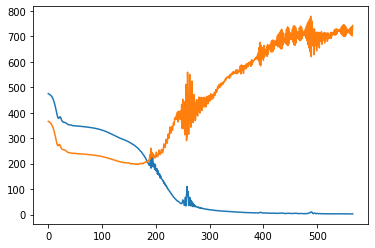

In [64]:
# Training loss vs Validation loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

###  1. Feature Importance

In [65]:
# Feature importance for model
explainer = dx.Explainer(model, X_train_mm, y_train, label='frog_count')
features = x.drop(['ppt','tmax','tmin','pet','def','srad'],axis=1).columns.to_list()
features

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 124 rows 7 cols
  -> target variable   : 124 values
  -> model_class       : keras.engine.sequential.Sequential (default)
  -> label             : frog_count
  -> predict function  : <function yhat_tf_regression at 0x000001CEAB4F6CB0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.91, mean = 10.5, max = 1.47e+02
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -11.9, mean = -0.303, max = 9.73
  -> model_info        : package keras

A new explainer has been created!


['aet', 'pdsi', 'q', 'soil', 'vap', 'vpd', 'ws']

In [66]:
# Generating dict to identlfy the feature names in the below visualization
di = {}
i = 0
for each in features:
    di[i] = each
    i=i+1
di

{0: 'aet', 1: 'pdsi', 2: 'q', 3: 'soil', 4: 'vap', 5: 'vpd', 6: 'ws'}

In [67]:
#plotting the variable importance chart
explainer.model_parts().plot()


## Saving model prediction into csv file

#prediction = pd.DataFrame(PredTestSet, columns=["prediction"])

# save the dataframe as a csv file (you may change the name of the csv file)
#prediction.to_csv("result.csv", index=False)

## Making a submission on the Platform

In [68]:
## An out-of-sample validation dataset has been provided for predicting the frog density on specified regions.
## Contestants should update the file with the predicted values & upload on the EY platform for evaluation. 